In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import h5py

import sys
sys.path.append("..")
sys.path.append("../..")
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [11]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:4'

In [12]:
# get data
# 几何区域：0<=x<=2*pi, 0<=t<=1
# 离散化：101*101网格
# res: 所有散点坐标
# b_left, b_right, b_upper, b_lower：边界点坐标

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [0, 0.6], 101, 101) 
res_test, _, _, _, _ = get_data([-1, 1], [0, 0.6], 101, 101) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_init[:,0:1], b_init[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [13]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

/tmp/ipykernel_65576/2938655338.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [14]:
# trian
loss_track = []

for i in tqdm(range(1000)):
    def closure():
        pred_res = model(x_res, t_res)  # (n, 1)
        pred_init = model(x_init, t_init)  # init
        pred_left = model(x_left, t_left)  # right
        pred_right = model(x_right, t_right)  # left

        u = pred_res
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + u * u_x) ** 2)
        loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)  # 边界：u(0, t) = 1, t>=0; u(1, t) = 0, t>=0
        loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0
        # print('loss: ', loss_res, loss_bc, loss_ic)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 1000/1000 [2:05:50<00:00,  7.55s/it] 


In [15]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000002, Loss_BC: 0.000000, Loss_IC: 0.000002
Train Loss: 0.000004


(101, 101)
relative L1 error: 1.024357
relative L2 error: 0.997462


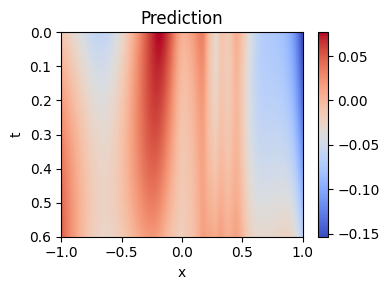

In [16]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
pred = pred.reshape(101, 101)
print(pred.shape)

mat = scipy.io.loadmat('./burgers_move.mat')
u = mat['u'].reshape(101,101)

# print(u.shape)
rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
# pred = pred.cpu().numpy() 
# u = u.cpu().numpy()
# L2re = L2RE(u, pred).mean()
# MaxE = MaxError(u, pred).mean()
# Mse = MSE(u, pred).mean()
# Rmse = RMSE(u, pred).mean()

# print("MSE: ", Mse.detach().cpu().numpy())
# print("RMSE: ", Rmse.detach().cpu().numpy())
# print("L2RE: ", L2re.detach().cpu().numpy())
# print("MaxE: ", MaxE.detach().cpu().numpy())

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_pinns_pred.png')
plt.show()

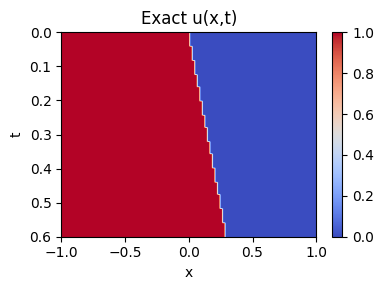

In [17]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/exact.png')
plt.show()

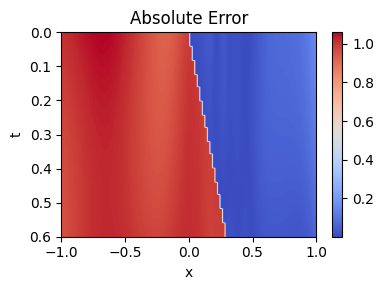

In [18]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/pinnsformer_error.png')
plt.show()